<p align="center">
  <img width="421" alt="logo" src="https://user-images.githubusercontent.com/76659596/113596851-2e5cc280-963b-11eb-8526-fb8fca9c837e.png">
</p>

#### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

#### Import Dataset

In [2]:
dataset = pd.read_excel(
                '../data/sentences_with_sentiment.xlsx',
                sheet_name='Sheet1',
                index_col=0)

#### List first five rows to check how the data looks

In [3]:
dataset.head(5)

,Sentence,Positive,Negative,Neutral
ID,,,,
1,The results in 2nd line treatment show an ORR ...,1,0,0
2,The long duration of response and high durable...,1,0,0
3,The median OS time in the updated results exce...,0,0,1
4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
5,"The data provided in 1st line, although prelim...",1,0,0


### Exploratory Data Analysis (EDA)

#### View the summary of the dataset

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 1 to 266
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  266 non-null    object
 1   Positive  266 non-null    int64 
 2   Negative  266 non-null    int64 
 3   Neutral   266 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 10.4+ KB


#### Check if there exists null entries

In [5]:
dataset.isnull().sum()

Sentence    0
Positive    0
Negative    0
Neutral     0
dtype: int64

#### Check how many positive comments the dataset has

In [6]:
dataset['Positive'].value_counts()

1    160
0    106
Name: Positive, dtype: int64

#### Check how many negative comments the dataset has

In [7]:
dataset['Negative'].value_counts()

0    230
1     36
Name: Negative, dtype: int64

#### Check how many neutral comments the dataset has

In [8]:
dataset['Neutral'].value_counts()

0    196
1     70
Name: Neutral, dtype: int64

#### Check if the labels are mutually exclusive

In [9]:
dataset[(dataset['Positive'] == 1) & ((dataset['Negative'] == 1) | (dataset['Neutral'] == 1))].count()

Sentence    0
Positive    0
Negative    0
Neutral     0
dtype: int64

#### Check for only whitespace strings in Sentence column

In [10]:
white_space = []  # start with an empty list

for i,sent,pos,neg,neutral in dataset.itertuples():
    if type(sent)==str and sent.isspace():
        white_space.append(i)

len(white_space)

0

The target columns do not contain any `null` entries

#### Create a new column for multi-class classification

Easy Algorithm:

* Multiply any positive number to all the entries in `Positive` column
* Multiply any negative number to all the entries in `Negative` column
* Add these values together
* If the result is as same as the positive number, the sentiment to be assigned is `Positive` in `Sentiment` column
* If the result is as same as the negative number, the sentiment to be assigned is `Negative` in `Sentiment` column
* If the result is 0, the sentiment to be assigned is `Neutral` in `Sentiment` column

In [11]:
dataset['Sentiment'] = dataset['Positive'] * 100 + dataset['Negative'] * (-100)
dataset['Sentiment'] = dataset['Sentiment'].map({100: 'Positive', -100: 'Negative', 0: 'Neutral'})

#### Check if the new column is created with the correct labels

In [12]:
dataset.head(15)

,Sentence,Positive,Negative,Neutral,Sentiment
ID,,,,,
1,The results in 2nd line treatment show an ORR ...,1,0,0,Positive
2,The long duration of response and high durable...,1,0,0,Positive
3,The median OS time in the updated results exce...,0,0,1,Neutral
4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0,Positive
5,"The data provided in 1st line, although prelim...",1,0,0,Positive
6,Taking into account the intrinsic limitation o...,1,0,0,Positive
7,This medicinal product has been authorised und...,0,0,1,Neutral
8,This means that further evidence on this medic...,0,1,0,Negative
9,The European Medicines Agency will review new ...,0,0,1,Neutral


#### Verify the counts of the sentiments in the new column

In [13]:
dataset['Sentiment'].value_counts()

Positive    160
Neutral      70
Negative     36
Name: Sentiment, dtype: int64

#### Plot the counts of the sentiments

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

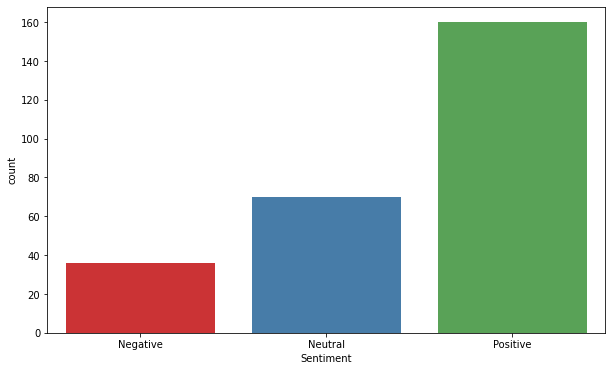

In [14]:
fig = plt.figure(figsize=(10,6))
sns.countplot(x='Sentiment', data=dataset, palette='Set1', order=['Negative', 'Neutral', 'Positive'])

According to the above counts and the count plot clearly indicate that the data is **unbalanced**

### Data Cleaning

#### Convert text to lower case

In [15]:
def convert_to_lower_case(text):
    return " ".join(text.lower() for text in text.split())

dataset['Sentence'] = dataset['Sentence'].apply(lambda sentence: convert_to_lower_case(sentence))

#### Check if the sentences have been lower-cased

In [16]:
dataset.head(2)

,Sentence,Positive,Negative,Neutral,Sentiment
ID,,,,,
1,the results in 2nd line treatment show an orr ...,1,0,0,Positive
2,the long duration of response and high durable...,1,0,0,Positive


#### Remove punctuations

In [17]:
# An example sentence before removing punctuation

dataset['Sentence'][7]

'this medicinal product has been authorised under a so-called ‘conditional approval’ scheme'

In [18]:
def remove_punctuations(text):
    return re.sub(r'[^\w\s]','',text)

dataset['Sentence'] = dataset['Sentence'].apply(lambda sentence: remove_punctuations(sentence))

#### Check if the punctuations from a specific sentence with punctuation have been removed

In [19]:
# The same sentence after removing punctuation
dataset['Sentence'][7]

'this medicinal product has been authorised under a socalled conditional approval scheme'

#### Fix misspelled words if any

It is not expected to have any spelling mistakes in the EPARs. However, one small spelling mistake is found which is corrected below.

Libraries like `TextBlob` can be used to find the spelling mistakes and correct them automatically. But, it will lead to further problems since pharmaceutical
terminologies don't exist in `TextBlob`'s english corpus. Hence, auto-correction hasn't been applied.

However, as a precaution, the data has been copied as text and manually reviewed on online spell checker to find out about any spelling mistake.

#### The sentence with wrong spelling of `profile` -> `proflie`

In [20]:
dataset['Sentence'][29]

'although dataset of afl patients has been updated data are still considered very limited to reach firm conclusion about safety proflie'

In [21]:
def fix_misspelled_words(text):
    mispelled_dict = {'proflie': 'profile'}

    for word in mispelled_dict.keys():
        text = text.replace(word, mispelled_dict[word])
    return text

dataset['Sentence'] = dataset['Sentence'].apply(lambda sentence: fix_misspelled_words(sentence))

#### The above sentence with spelling mistake has been fixed
`proflie` is corrected to `profile`

In [22]:
dataset['Sentence'][29]

'although dataset of afl patients has been updated data are still considered very limited to reach firm conclusion about safety profile'

#### Remove stopwords

In [23]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stopwords(text):
    return " ".join(x for x in text.split() if x not in stop_words)

dataset['Sentence'] = dataset['Sentence'].apply(lambda sentence: remove_stopwords(sentence))

[nltk_data] Downloading package stopwords to /Users/amit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Check if the stopwords have been removed from a specific sentence containing stopwords

In [24]:
dataset['Sentence'][1]

'results 2nd line treatment show orr 33 patients durable responses resulting apparent pfs plateau'

#### Lemmatization

#### Disable unnecessary pipelines to speed up

In [25]:
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [26]:
# def lemmatise(text):
#   doc = nlp(text)
#   return " ".join([token.lemma_ for token in doc])

Using lemmatization or stemming in the sentiment analysis is debatable topic.
Though it has advantages mainly reducing the corpus size/noise, it may break
the parts of speech tagging.

In [27]:
# dataset['Sentence'] = dataset['Sentence'].apply(lambda sentence: lemmatise(sentence))

### Data Preprocessing

In [28]:
X = dataset['Sentence']
y = dataset['Sentiment']

#### Encode target labels in the Sentiment column for multi-class text classification

In [29]:
le = LabelEncoder()
y = le.fit_transform(y)

#### List the target classes and associated labels from the encoder

In [30]:
# target labels with value between 0 and n_classes-1 from left to right
list(le.classes_)

['Negative', 'Neutral', 'Positive']

#### TF-IDF vectorizer

In [31]:
vectorizer = TfidfVectorizer(max_features=2500, max_df=0.8, min_df=4)
X = vectorizer.fit_transform(X)

#### Train test split with result reproducibility using specified random seed

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

The plan is to implement few classical machine learning classifiers to check the accuracy of the model.
Since all classical machine learning classifiers can share the same base imlementation, in this
notebook, we are going to implement only one or two classical machine learning classifier(s) and the rest of the
implementations will be available in the source code as python files.

#### Support Vector Machine (SVM)

#### Define the SVM classifier

In [52]:
classifier_svm = SVC(kernel = 'rbf', random_state = 0)

#### Fit the SVM classifier (linear) on the training data

In [53]:
classifier_svm.fit(X_train, y_train)

SVC(random_state=0)

#### Prediction on the test data

In [54]:
svm_pred = classifier_svm.predict(X_test)

#### Evaluation Matrices

##### Confusion Matrix

In [55]:
print(confusion_matrix(y_test, svm_pred))

[[ 1  0  6]
 [ 0  3 13]
 [ 0  0 31]]


##### Classification Report

In [56]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       1.00      0.19      0.32        16
           2       0.62      1.00      0.77        31

    accuracy                           0.65        54
   macro avg       0.87      0.44      0.44        54
weighted avg       0.78      0.65      0.57        54



##### Accuracy Score

In [38]:
print(accuracy_score(y_test, svm_pred))

0.6666666666666666


#### Apply k-Fold Cross Validation

In [39]:
accuracies = cross_val_score(estimator = classifier_svm, X = X_train, y = y_train, cv = 10)

#### Standard deviation of the accuracy

In [40]:
print(f"{accuracies.std() * 100:.2f}")

5.40


#### Mean accuracy score

In [41]:
print(f"{accuracies.mean() * 100:.2f}%")

72.23%


#### Grid Search

In [42]:
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = SVC(kernel = 'rbf', random_state = 0),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
                         {'C': [0.25, 0.5, 0.75, 1],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']}],
             scoring='accuracy')

#### Best Accuracy

In [43]:
best_accuracy = grid_search.best_score_
print(f"{best_accuracy*100:.2f}%")

72.23%


#### Best Parameters

In [44]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'C': 1, 'kernel': 'linear'}


#### Linear Support Vector Classifier

Since by default, `LinearSVC` minimizes the squared hinge loss
in comparison with SVC with a linear kernel that minimizes the regular
hinge loss, the LinearSVC` may perform differently.

In [45]:
lin_svc = LinearSVC(random_state=17)
lin_svc.fit(X_train, y_train)
lin_svc_pred = lin_svc.predict(X_test)

#### Classification Report

In [46]:
print(classification_report(y_test, lin_svc_pred))

              precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.58      0.44      0.50        16
           2       0.75      0.87      0.81        31

    accuracy                           0.70        54
   macro avg       0.67      0.63      0.64        54
weighted avg       0.69      0.70      0.69        54



#### Confusion Matrix

In [47]:
print(confusion_matrix(y_test, lin_svc_pred))

[[ 4  1  2]
 [ 2  7  7]
 [ 0  4 27]]


#### Accuracy Score

In [48]:
print(accuracy_score(y_test, lin_svc_pred))

0.7037037037037037


Calculate cross-validation accuracies for `LinearSV` classifier

In [49]:
accuracies = cross_val_score(
                estimator = LinearSVC(random_state=10),
                X = X,
                y = y,
                cv = 10)

#### Standard Deviation

In [50]:
print(f"{accuracies.std() * 100:.2f}")

11.68


#### Mean Accuracy

In [51]:
print(f"{accuracies.mean() * 100:.2f}%")

68.72%


### Conclusion

So far the following classifiers have been evaulated:

* Support Vector Machine with Gaussian and Linear Kernels
* Linear Support Vector

In the first case, the linear kernel SVM results in higher accuracy
than the gaussian kernel. Given the result obtained in the previous
tests, it was worth to look at the linear SVC model that uses different
loss function than the SVM with linear kernel. And the test for the
linear SVC resulted in better performance (`f1 score`, `precision` and
`recall` for imbalanced dataset) for the negative and neutral
sentiments.

In the python sources, one can test many other classical machine learning
classifiers as well as Bidirectional Long Short Term Memory (LSTM) Recurrent
Neural Network (RNN) deep learning model.
